In [40]:
# Necessary
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchdiffeq import odeint_adjoint as odeint
from jupyterthemes import jtplot
jtplot.style(theme="chesterish")
 # CONSTANT 
device = "cpu"
EPOCHS=1
BATCH_SIZE=32
IMG_SIZE=(32,32,3)

In [3]:
# Data incoming 
cifar = torchvision.datasets.CIFAR10("./data/")
data_loader = torch.utils.data.DataLoader(cifar, batch_size=BATCH_SIZE, shuffle=True)

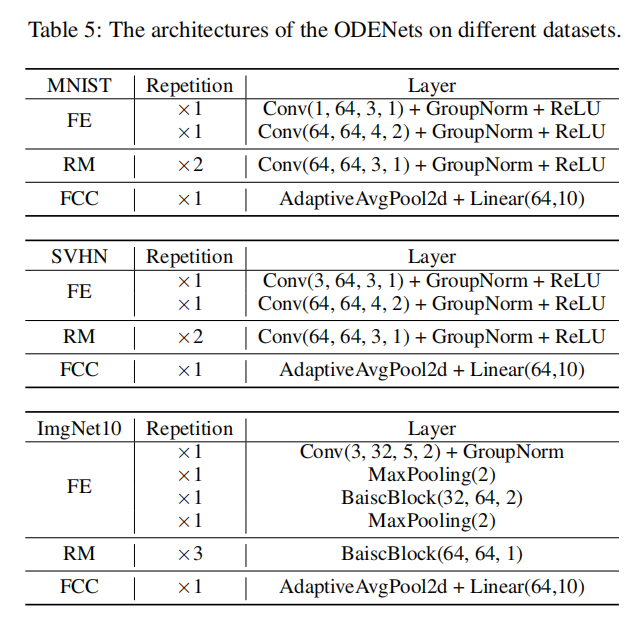
Conv(in_channels, out_channels, kernel_size, stride)
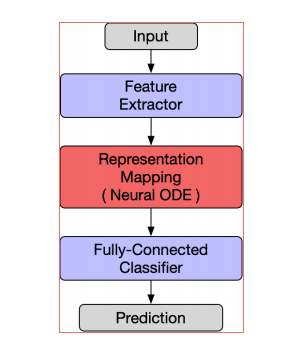

In [68]:
class ODEBlock(nn.Module):
    def __init__(self):
        super(ODEBlock,self).__init__()
        self.block = nn.Sequential(*[
            nn.Conv2d(64,64,3,1, padding=1),
            nn.GroupNorm(4,64),
            nn.ReLU(), 
            nn.Conv2d(64,64,3,1, padding=1),
            nn.GroupNorm(4,64),
            nn.ReLU()
        ]) 
    def forward(self,t,x):
        return self.block(x)
    #pass
     
class ODENet(nn.Module):
    def __init__(self, func):
        super(ODENet, self).__init__()
        assert isinstance(func, ODEBlock), f"argument function is not NeuralODEs model"
        self.fe = nn.Sequential(*[nn.Conv2d(1,64,3,1),
                                  nn.GroupNorm(4,64),
                                  nn.ReLU(),
                                  nn.Conv2d(64,64,4,2),
                                  nn.GroupNorm(4,64),
                                  #1x64x12x12
                                  nn.ReLU()])
        self.rm = func
        self.fcc = nn.Sequential(*[nn.Conv2d(64,1,3,1,padding=1),
                                   nn.AdaptiveAvgPool2d(8),
                                   # 1 x 64 x 8 x 8
                                   nn.Flatten(),
                                   # 4096
                                   nn.Linear(64,10),
                                   nn.Softmax()])
        self.intergrated_time = torch.Tensor([0.,1.]).float()
    def forward(self,x):
        out = self.fe(x)
        out = odeint(self.rm, out, self.intergrated_time)[1]
        #out = self.rm(out)
        out = self.fcc(out)
        return out
    def evaluate(self, test_loader):
        correct = 0
        total = 0 
        running_loss = 0
        
        with torch.no_grad():
            for test_data in test_loader:
                data, label = test_data
                outputs = self.forward(data)
                _, correct_labels = torch.max(labels, 1) 
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == correct_labels).sum().item()
                running_loss += F.torch.nn.functional.binary_cross_entropy_with_logits(
                    outputs.float(), labels.float()).item()
        acc = round(correct/toral * 1.0 , 2)
        
        return running_loss,acc

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.net = nn.Sequential(*[
            nn.Conv2d(1,64,3,1),
            nn.GroupNorm(4,64),
            nn.ReLU(),
            nn.Conv2d(64,64,4,2),
            nn.GroupNorm(4,64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1, padding=1),
            nn.GroupNorm(4,64),
            nn.ReLU(), 
            nn.Conv2d(64,64,3,1, padding=1),
            nn.GroupNorm(4,64),
            nn.ReLU(),
            nn.Conv2d(64,1,3,1,padding=1),
            nn.AdaptiveAvgPool2d(8),
            nn.Flatten(),
            nn.Linear(64,10),
            nn.Softmax()
        ])
    def forward(self,x):
        return self.net(x)
    def evaluate(self, test_loader):
        correct = 0
        total = 0 
        running_loss = 0
        
        with torch.no_grad():
            for test_data in test_loader:
                data, label = test_data
                outputs = self.forward(data)
                _, correct_labels = torch.max(labels, 1) 
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == correct_labels).sum().item()
                running_loss += F.torch.nn.functional.binary_cross_entropy_with_logits(
                    outputs.float(), labels.float()).item()
        acc = round(correct/toral * 1.0 , 2)
        
        return running_loss,acc

In [69]:
def add_noise(converted_data, sigma = 10):
    pertubed_data = converted_data + torch.normal(torch.zeros(converted_data.shape),
                                                  torch.ones(converted_data.shape) * sigma)
    return pertubed_data
def preprocess_data(data, shape = (28,28)):
    X = []
    Y = []
    for data_idx, (x,y) in list(enumerate(data)):
        X.append(np.array(x).reshape((1,shape[0],shape[0])))
        Y.append(y)
    y_data = F.one_hot(torch.Tensor(Y).to(torch.int64), num_classes=10)
    x_data = torch.Tensor(X)
    ds = TensorDataset(x_data,y_data)
    x_noise_data = add_noise(x_data)
    pertubed_ds = TensorDataset(x_noise_data,y_data)
    ds_len = len(Y)
    return ds_len, ds, pertubed_ds
# Adversarial Attack chua code ne`, nho code vo, xin cam on

In [45]:
# Test   
test_input = torch.rand((1,1,28,28))
ode_block = ODEBlock()
model = ODENet(ode_block)
#model(test_input).shape
#Test OK

In [46]:
# Load data
DIR = "./data/mnist/"
MNIST = torchvision.datasets.MNIST(DIR,
                                   train=True,
                                   transform=None,
                                   target_transform=None, download=False)

ds_len_, normal_ds_, pertubed_ds_ = preprocess_data(MNIST)


In [70]:
def train_model(model, optimizer, train_loader, val_loader,loss_fn, epochs=100):
    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
    for epoch_id in tqdm(range(epochs)):
        total = 0
        correct = 0
        running_loss = 0
        for batch_id, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, correct_labels = torch.max(labels, 1)
            #print(labels)
            total += labels.size(0)
            correct += (predicted == correct_labels).sum().item()
            #print(labels.shape, outputs.shape)
            loss = loss_fn(outputs.float(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() 
        acc = round(correct/total * 1.0, 2)
        history["acc"].append(acc)
        history["loss"].append(loss)
        val_loss, val_acc = model.evaluate(val_loader)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch(s) {epoch_id + 1} | loss: {loss} | acc: {acc} | val_loss: {val_loss} | val_acc: {val_acc}")
    return model, history
def main(ds_len, ds, name = "mnist_normal",batch_size=32,epochs=100, lr=1e-3):
    number_of_train = int(ds_len * 0.7)
    number_of_val = ds_len - number_of_train
    print(f"Number of train: {number_of_train}\nNumber of validation: {number_of_val}")
    train_set, val_set = torch.utils.data.random_split(ds,
                                                       [number_of_train,number_of_val])
    #print(type(train_set))
    assert isinstance(train_set,torch.utils.data.Dataset)
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_set, shuffle=True)
    loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
    ode_func = ODEBlock()
    ode_model = ODENet(ode_func)
    ode_optimizer = torch.optim.Adam(ode_model.parameters(), lr=lr)
    dnn_model = Network()
    dnn_optimizer = torch.optim.Adam(dnn_model.parameters(), lr=lr)
    ode_his = train_model(ode_model,
                          ode_optimizer,
                          train_loader, val_loader, loss_fn=loss_fn, epochs=1)
    dnn_his = train_model(dnn_model, 
                         dnn_optimizer,
                         train_loader, val_loader, loss_fn=loss_fn,epochs=1)
    

In [ ]:
main(ds_len_,normal_ds_)

Number of train: 42000
Number of validation: 18000


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([32, 10]) torch.Size([32, 10])
torch.Size([32, 10]) torch.Size([32, 10])
torch.Size([32, 10]) torch.Size([32, 10])
torch.Size([32, 10]) torch.Size([32, 10])
